In [1]:
import copy

import numpy as np
from Trip import Trip
from Point import Point
from Trips import Trips
import math
import matplotlib.pyplot as plt
import gurobipy as gb
from Simulation import Simulation
from Solver import Solver


In [2]:
# FIX IT
# TODO error when n=10, m=1 because n_realocation_moves becomes 0 so all trips have 0 reallocation moves except the last one which has all reallocation moves
def sa_approach(n,m,ks,kr,kn,T_start,c,J,D,start_point,end_point):
    # ks -> number of restarts
    # kr -> number of rehats
    # T_start -> initial temperature
    # c -> cooling parameter
    # J -> realocation moves
    # D -> drop off points
    # By varying these parameters and caching not only the best solution found so far, but also the temporary best solution, i.e., before reheat and restart
    # we obtain a pool of taxi trips by splitting the cached solutions, i.e., taxi tour, into the single trips

    for t in range(ks):
        # generate random feasible solution
        print(t)
        realocation_moves=copy.deepcopy(J)
        drop_off_points=copy.deepcopy(D)

        # set initial current state sc
        n_trips=int(np.ceil(n/(np.ceil((m+1)/2))))
        trips=[]

        for i in range(n_trips):
            k=np.random.randint(1,m+1) # number of drop-off points
            pi=np.random.choice(drop_off_points, k,replace=False) #These drop-off points are randomly chosen
            pi=pi.tolist()

            #end and start point
            pi.insert(0,start_point)
            pi.append(end_point)

            # the relocation moves are randomly spread between the different trips.

            n_realocation_moves=int(len(J)/n_trips) # TODO we can improve using the normal distribution to select the right dimension

            J_prime=np.random.choice(realocation_moves, n_realocation_moves,replace=False)
            J_prime=J_prime.tolist()
            if i==n_trips-1:
                J_prime=copy.deepcopy(realocation_moves)
            for j in J_prime:
                realocation_moves.remove(j)

            trip=Trip(J_prime,pi,k)
            trips.append(trip)
            # Finally, for each trip and its assigned relocation moves, we execute each relocation from the closest drop-off point increasing the trip duration least.

            # if I understood well, it means we have to take the closest drop off point to the relocation moves to select in the time duration


        trips_star=copy.deepcopy(trips) # optimal solution
        for j in range(kr):
            T=T_start
            not_improved=0
            new_trips=copy.deepcopy(trips)
            while not_improved<kn and T!=0:
                not_improved+=1

                # Sn= neighbour of current state Sc
                selected_indexes_trips=np.random.choice(range(len(new_trips)), 2,replace=False)
                selected_indexes_trips=selected_indexes_trips.tolist()
                trip1=copy.deepcopy(new_trips[selected_indexes_trips[0]])
                trip2=copy.deepcopy(new_trips[selected_indexes_trips[1]])

                # select an action
                n_actions=np.random.randint(0,5)
                match n_actions:
                    case 0:
                        # Swap two relocation moves between two taxi trips
                        Trips.swap_random_realocation_moves(trip1,trip2)
                    case 1:
                        # Move a relocation move to another taxi trip
                        Trips.move_random_realocation_moves(trip1,trip2)

                    case 2:
                        # Remove a drop-off point from a taxi trip
                        Trips.remove_random_dropoff(trip1)

                    case 3:
                        # Swap two drop-off points between two taxi trips
                        Trips.swap_random_dropoff(trip1,trip2)

                    case 4:
                        # Add a drop-off point to a taxi trip
                        pi=np.random.choice(D, 1)[0]
                        Trips.add_drop_off(trip1,pi)

                new_trips[selected_indexes_trips[0]]=trip1
                new_trips[selected_indexes_trips[1]]=trip2

                z_trips=Trips.get_total_duration(trips)
                z_new_trips=Trips.get_total_duration(new_trips)

                if(z_new_trips<z_trips):
                    # sc=sn update current
                    trips=new_trips
                    z_trips=z_new_trips
                    not_improved=0
                    z_trips_star=Trips.get_total_duration(trips_star)
                    if(z_trips<z_trips_star):
                        trips_star=copy.deepcopy(trips)
                else:
                    #with probability exp() assign sc=sn
                    exp_lambda= (z_new_trips-z_trips)/T
                    if abs(exp_lambda)>np.finfo(float).eps:
                        exponential_sample=np.random.exponential(1.0/exp_lambda) # TODO sistemare calcolo probabilità
                        trips=new_trips if exponential_sample<1.0/exp_lambda else trips # sc=sn if probability else sc
                T=T*c
    return trips_star


In [3]:
n,m,ks,kr,kn,T_start,c=Simulation.get_simulation_number(0)

In [4]:
J,D=Simulation.initialize_map(n)

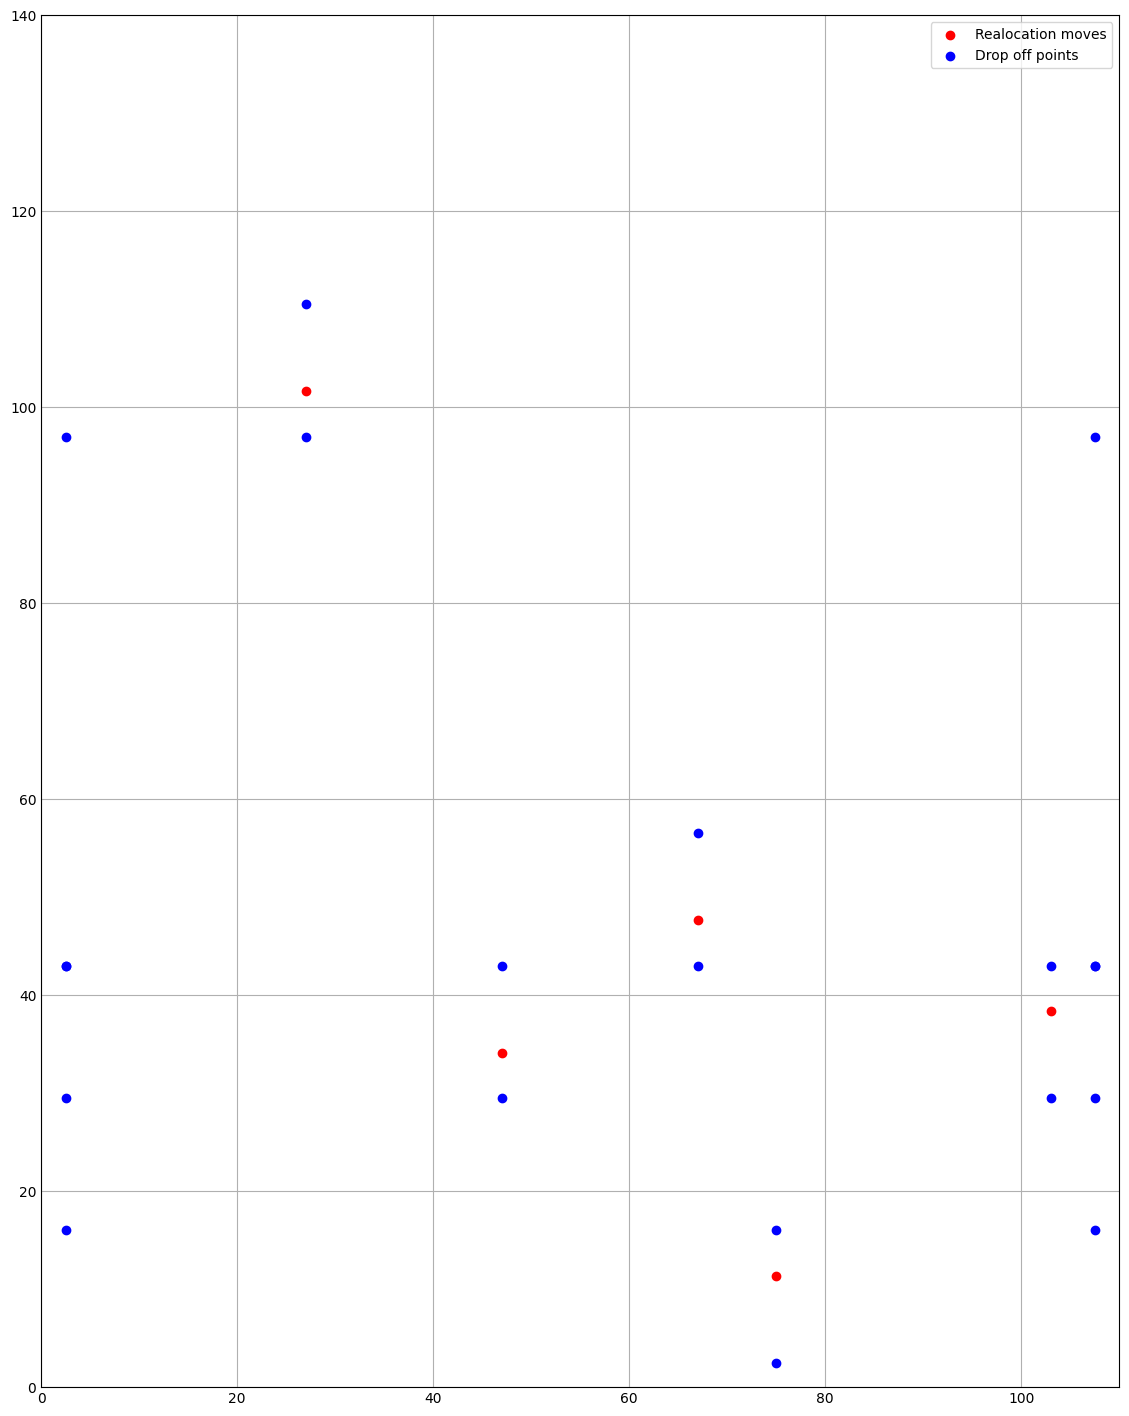

In [5]:
Simulation.plot_map(J,D,[])

In [6]:
trips=Solver.sa_approach(n,m,ks,kr,kn,T_start,c,J,D,Point(0,0),Point(0,0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [7]:
trips


[<Trip.Trip at 0x114aa2a10>, <Trip.Trip at 0x114aa3130>]

In [8]:
Trips.get_total_duration(trips)

174.66787044071083

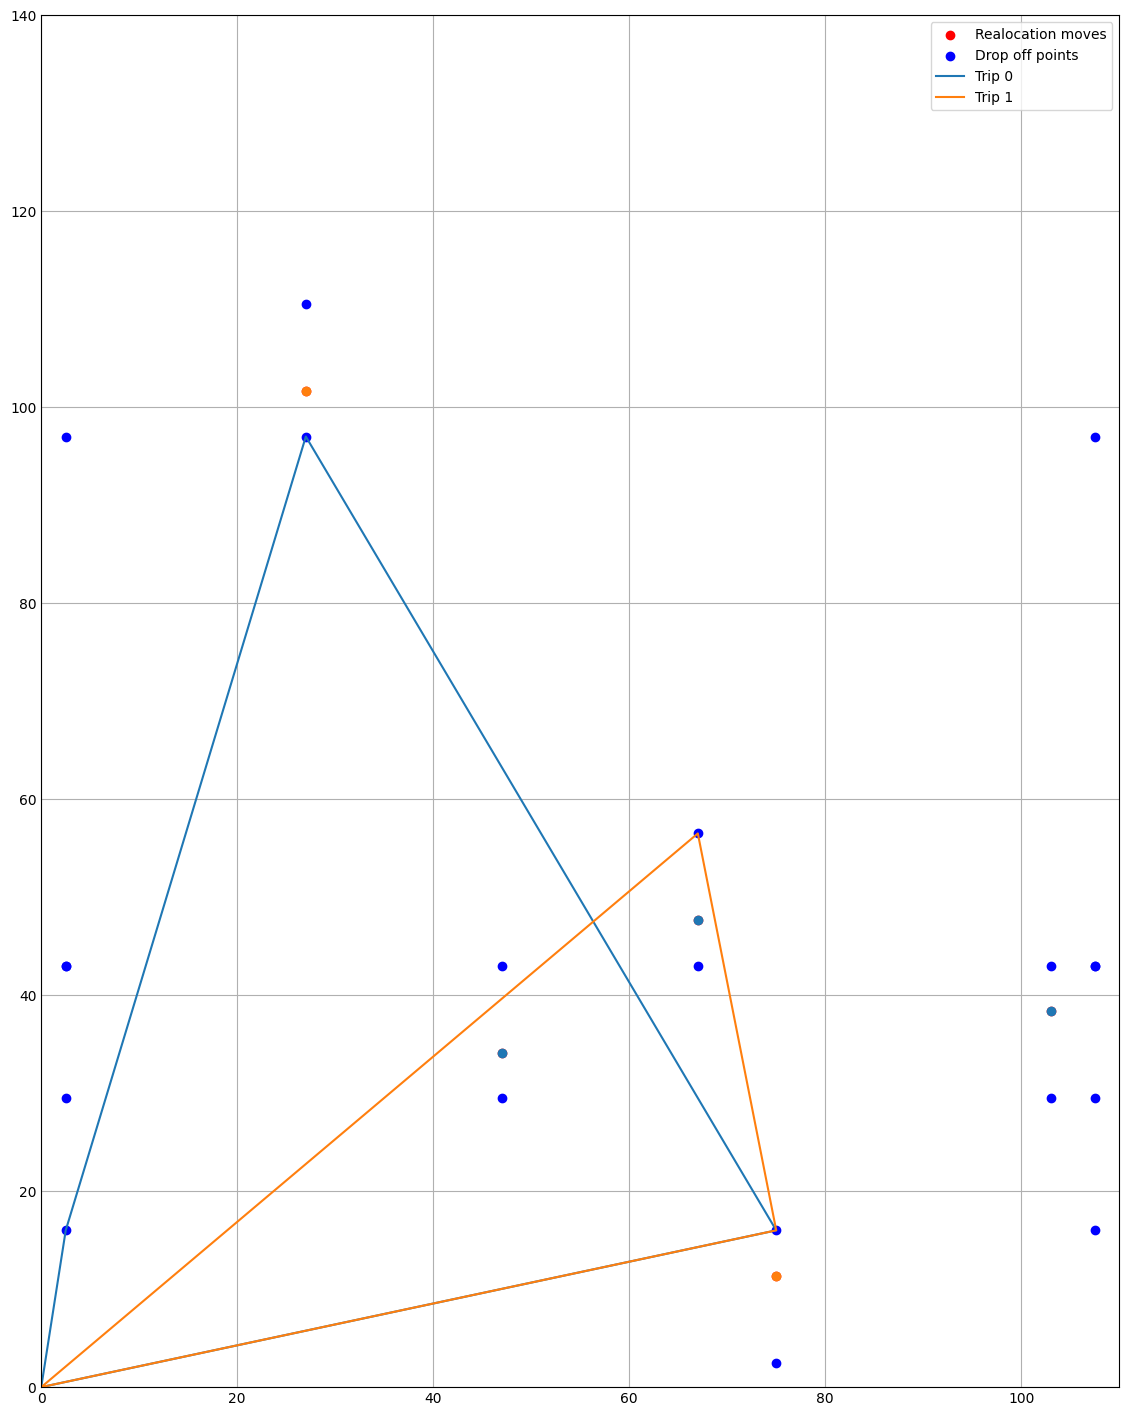

In [9]:
Simulation.plot_map(J,D,trips)

In [12]:
print(trips[0])

J: (103,38.375) (47,34.125) (67,47.625) pi: (0,0) (2.5,16.0) (27,97.0) (75,16.0) (0,0) k=3


In [9]:
trips[1].pi


In [8]:
ks


13